# Питон и машинное обучение

# Модуль 4. Настройка моделей

Цель сегодняшнего семинара - дать инструментарий и познакомить с возможностями повышения качества работы моделей, дать понять, какие факторы и в данных, и в самой модели, и в процессе обучения влияют на ее качество.

Мы начнем с простого примера и закончим наладкой работы модели "Случайный лес" на реальных датасетах.

Различные аспекты настройки моделей:

- недообучение и переобучение модели:
    - bias/variance trade-off
    - кросс-валидация
- подбор параметров модели:
    - случайный поиск
    - перебор параметров с кросс-валидацией, ```GridSearchCV```
- отбор признаков средствами машинного обучения



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('always', category=UserWarning)

## Валидация модели

Мы уже знакомы с функцией ```train_test_split```, она разбивает наши данные на обучающую и контрольную (тестовую, __валидационную__) выборки. Давайте рассмотрим некоторые аспекты ее работы. 

Разобъем датасет в соотношении 50/50:

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                   test_size=0.5, 
                                                   random_state=20231110,
                                                   stratify = y)

print(X_train.shape)
print(X_val.shape)

Обучим "лес" и проверим точность его работы на обучающей и контрольной выборке:

In [ ]:
model1 = RandomForestClassifier(n_estimators=8, max_depth=5, n_jobs=-1) 
model1.fit(X_train,y_train)

pred_train1 = model1.predict(X_train)
pred_val1 = model1.predict(X_val)

print(pred_train1[:20])
print(pred_val1[:20])
print(y_val[:20])

print(f"Accuracy score on Training set: {accuracy_score(y_train, pred_train1)}")
print(f"Accuracy score on Validation set: {accuracy_score(y_val, pred_val1)}")

Какие выводы можно сделать, глядя на результат работы классификатора?

Обучим классификатор с теми же параметрами на всем множестве:

In [ ]:
model2 = RandomForestClassifier(n_estimators=8, max_depth=5, n_jobs=-1) 
model2.fit(X,y)

pred = model2.predict(X)

print(pred[:20])
print(y_val[:20])

print(f"Accuracy score on Whole dataset: {accuracy_score(y, pred)}")


Какие выводы можно сделать?

<hr>

Качество работы классификатора зависит от данных. Это особенно актуально в задачах с несбалансированными классами. Для того, чтобы получить усредненное значение метрики качества работы модели при обучении ее на различных порциях данных, выполяют процедуру __кросс-валидации__: обучают модель на различных порциях данных и вычисляют среднее значение и разброс:

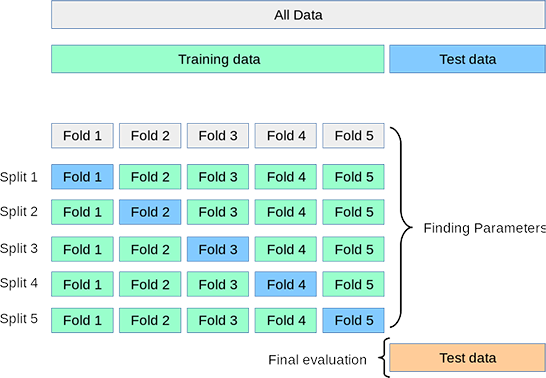

In [ ]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=20231110,
                                                   stratify = y)

print("Train size: ", X_train.shape)
print("Test size: ", X_test.shape)

model = RandomForestClassifier(n_estimators=10, max_depth=5, 
                               n_jobs=-1, 
                               random_state=42)

K = 5

print(f"Fold of {K} folds size: ~{X_train.shape[0]//5}")

scores = cross_val_score(model, X_train, y_train, cv=K, scoring="accuracy")
print(scores)
print(f"CV score mean: {scores.mean()}")
print(f"CV score std: {scores.std()}")

model.fit(X_train, y_train)

print(f"Score on test set: {accuracy_score(y_test, model.predict(X_test))}")

Процесс разделения датасета на части называется __фолдингом__. Функция ```cross_val_score()``` просто разбивает данные на последовательные K частей. Для большего контроля над этим процессом существует множество функций - итераторов, которые формируют соответствующие подмножества данных в соответствии с выбранной стратегией. О них можно прочитать в [официальной документации](https://scikit-learn.org/stable/modules/cross_validation.html). Наиболее часто используемые стратегии - ```KFold``` и  ```StratifiedKFold```.

In [ ]:
# посмотрим на последовательность данных в таргете датасета
y[:20]

In [ ]:
# сделаем фолдинг и посмотрим на индексы для таргета трейн-сета
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kf = KFold(n_splits=5)
for train, test in kf.split(X_train, y_train):
    print('[', *test[:3], '...', *test[-3:], ']')

print()

skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X_train, y_train):
    print('[', *test[:3], '...', *test[-3:], ']')


Если посмотреть на разброс значений метрики на кросс-валидации - мы видим, что стратифицированный фолдинг уменьшает его.

In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
print(scores)
print(f"CV score KFold mean: {scores.mean()}")
print(f"CV score KFold std: {scores.std()}")

print()

scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy")
print(scores)
print(f"CV score S-KFold mean: {scores.mean()}")
print(f"CV score S-KFold std: {scores.std()}")

## Недообучение и переобучение

Рассмотрим на примере полиномиальной регрессии. Мы будем пытаться аппроксимировать синететические данные при помощи многочленов степени n и посмотрим, при каких значениях n наша модель недообучается или переобучается.

In [ ]:
def f(x, std=0.5):
    y = 10 - (x*5 - 2)**2
    return np.random.normal(y, std) if std > 0 else y

def make_data(N=40, error=1.0, random_seed=1):
    np.random.seed(random_seed)
    X = np.random.random(N)[:, np.newaxis]
    y = f(X.ravel(), error)
    
    return X, y

X, y = make_data(40, error=1)


x = np.linspace(0, 1.2, 100)
real_y = [f(i, 0) for i in x]

fig, ax = plt.subplots()
ax.set_ylim( (-3, 14) )
ax.scatter(X.ravel(), y, color='r', label="X")
ax.plot(x, real_y, 'k--', label="Correct y")
ax.legend()
plt.show()

Создадим модель полиномиальной регрессии с использованием ```PolynomialFeatures``` препроцессора, который можно ограничить линейной регрессией.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Сначала обучим линейную модель (многочлен степени (degree) 1) и посмотрим как он аппроксимирует наши данные:

In [ ]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

model1 = LinearRegression()
model1.fit(X, y)

y_test = model1.predict(X_test)

fig, ax = plt.subplots()
ax.set_ylim( (-3, 14) )
ax.plot(X_test.ravel(), y_test, label="Degree=1")
ax.plot(x, real_y, 'k--', label="Correct y")
ax.scatter(X.ravel(), y, color='r', label="X")
ax.legend()
ax.set_title(f"R2 error: {r2_score(model1.predict(X), y):.3g}")

plt.show()

Такая ситуация называется __high bias__ (высокое смещение) - модель __недообучилась__ (underfit). __Смещение__ в данном контексте - это мера ошибки. Высокая ошибка - высокое смещение.

Обучим многчлен степени, допустим, 12(!) и посмотрим как он аппроксимирует наши данные:

In [ ]:
model20 = PolynomialRegression(degree=20)
model20.fit(X, y)

y_test = model20.predict(X_test)

fig, ax = plt.subplots()
ax.set_ylim( (-3, 14) )
ax.plot(X_test.ravel(), y_test, label="Degree=20")
ax.plot(x, real_y, 'k--', label="Correct y")
ax.scatter(X.ravel(), y, color='r', label="X")
ax.legend()
ax.set_title(f"R2 error: {r2_score(model20.predict(X), y):.3g}")

plt.show()

Такая ситуация называется __high variance__ (высокий разброс, высокая вариативность) - модель __переобучилась__ (overfit). Значение этой меры можно получить не в рамках одного эксперимента, а в результате кросс-валидации, когда модели передаются разные порции данных. Это как раз и есть мера вариативности ответов алгоритма. Она же соответствует среднеквадратичному отклонению.

Чтобы получить ее, нужно посчитать разброс значений ошибок на кросс-валидации.

In [ ]:
# добавим данных
X, y = make_data(160, error=1)


x = np.linspace(0, 1.2, 100)
real_y = [f(i, 0) for i in x]

fig, ax = plt.subplots()
ax.set_ylim( (-3, 14) )
ax.scatter(X.ravel(), y, color='r', label="X")
ax.plot(x, real_y, 'k--', label="Correct y")
ax.legend()
plt.show()

In [ ]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=7, test_size=0.25, random_state=0)

scores = cross_val_score(model1, X, y, cv=ss, scoring="r2")
print(scores)
print(f"CV score mean (bias): {scores.mean()}")
print(f"CV score std (variance): {scores.std()}")

print()

scores = cross_val_score(model20, X, y, cv=ss, scoring="r2")
print(scores)
print(f"CV score mean (bias): {scores.mean()}")
print(f"CV score std (variance): {scores.std()}")


Наша задача - подобрать такую кофигурацию модели, которая минимизирует __bias__ и __variance__. Такой компромисс называется __bias/variance tradeoff__.

Bias и variance удобно визуализировать в виде __валидационной кривой__.

In [ ]:
from sklearn.model_selection import validation_curve

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

degrees = np.arange(1, 21)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       param_name='polynomialfeatures__degree', 
                                       param_range=degrees, cv=ss,
                                       scoring="r2")

plot_with_err(degrees, val_train, label='training scores')
plot_with_err(degrees, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('R2 error')
plt.gca().set_xticks(degrees)
plt.gca().set_ylim( (-1, 1) )
plt.legend();

Как несложно убедиться из графика, корректная степень - 2 (чего и следовало ожидать).

Построим график подобранной функции и фактического y:

In [ ]:
model = PolynomialRegression(degree=2)
model.fit(X, y)

y_test = model.predict(X_test)

fig, ax = plt.subplots()
ax.set_ylim( (-3, 14) )
ax.plot(X_test.ravel(), y_test, label="Degree=2")
ax.plot(x, real_y, 'k--', label="Correct y")
ax.scatter(X.ravel(), y, color='r', label="X")
ax.legend()
ax.set_title(f"R2 error: {r2_score(model.predict(X), y):.3g}")

plt.show()

## Влияние количества данных на модель

Нам важно найти ту точку в обучении модели, когда данных достаточно, но не больше.  Это можно изобразить, используя **кривые обучения** (**learning curves**).

Идея простая, мы отображаем ошибку как функцию от количества точек, используемых для обучения.

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),X, y, 
                                                  train_sizes=train_sizes, 
                                                  cv=ss,
                                                  scoring="r2")
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('R2 error')
    plt.ylim(-1, 1.1)
    plt.legend()
    
# построим для линейной регрессии
plot_learning_curve(degree=1)

In [ ]:
# построим для многочлена более высокой степени
plot_learning_curve(degree=2)


## Выводы

- Ошибка на обучающей выборке сама по себе ничего не говорит о качестве модели
- Кросс-валидационная ошибка показывает, насколько хорошо модель подстраивается под данные (имеющийся тренд в данных), сохраняя при этом способность обобщения на новые данные
- **Валидационная кривая** представляют собой график, показывающий результат на тренировочной и валидационной выборке в зависимости от **сложности модели**:
  + если две кривые распологаются близко, и обе ошибки велики, -  это признак *недообучения*
  + если две кривые далеко друг от друга, - это показатель *переобучения*
- **Кривая обучения**  - это график, показывающий результаты на валидации и тренировочной подвыборке в зависимости от количества наблюдений. 
  + если кривые близко, добавление новых данных не поможет.
  + если кривые далеко, добавление новых данных может улучшить результат.

#### ⁉️ Задание

Для датасета "рукописные цифры" и модели "Случайный лес" выполните следующее:
- постройте валидационную кривую, варьируя параметры ```n_estimators``` и ```max_depth```, выберите оптимальную модель
- подберите оптимальный размер разбиения датасета на обучающую и валидационные выборки.


In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=20231110,
                                                   stratify = y)

# ваш код здесь



Для ленивых: также можно производить оптимальную кросс-валидацию и автоматический подбор параметров при помощи функционала GridSearchCV:

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=42)

parametrs = { 'n_estimators': range(10, 20+1, 2),
              'max_depth': range(1,13, 2), 
            }

grid = GridSearchCV(clf, parametrs, cv=5, verbose=3)
grid.fit(X_train, y_train)
grid.best_params_

Ссылки на источники:
    
- [3.1. Cross-validation: evaluating estimator performance (scikit-learn.org)](https://scikit-learn.org/stable/modules/cross_validation.html)